In [343]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation
import matplotlib as mpl
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from classes.pca import PCA
from classes.kmeans import KMeans

In [344]:
g0 = Data(edge_index=torch.tensor([
    [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4],
    [0, 1, 3, 0, 1, 2, 1, 2, 4, 0, 3, 2, 4]]), pos=torch.tensor([[4.963, 7.682],
    [3.074, 6.341],[3.489, 4.017],[6.977, 8.   ],[1.61 , 2.823]],dtype=torch.float32),
    y=torch.tensor([2, 2, 2, 1, 1.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))

g1 = Data(edge_index=torch.tensor([
    [0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4],
    [0, 1, 2, 3, 0, 1, 0, 2, 4, 0, 3, 2, 4]]), pos=torch.tensor([[4.963, 4.012],
    [6.806, 5.142],[4.431, 6.432],[5.159, 1.636],[1.955, 6.691]], dtype=torch.float32),
    y=torch.tensor([3, 1, 2, 1, 1.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))

g2 = Data(edge_index=torch.tensor([
    [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4],
    [0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 3, 4, 0, 2, 3, 2, 4]]), pos=torch.tensor([[7.698, 7.945],
    [5.712, 7.06 ],[7.608, 5.876],[9.736, 6.541],[6.81 , 3.582]], dtype=torch.float32),
    y=torch.tensor([3, 2, 4, 2, 1.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))

g3 = Data(edge_index=torch.tensor([
    [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    [0, 1, 2, 0, 1, 4, 0, 2, 3, 2, 3, 4, 1, 3, 4]]), pos=torch.tensor([[4.488, 7.382],
    [5.241, 9.701],[5.269, 5.412],[7.128, 6.766],[7.317, 8.692]], dtype=torch.float32),
    y=torch.tensor([2, 2, 2, 2, 2.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))

g4 = Data(edge_index=torch.tensor([
    [0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    [0, 1, 2, 3, 4, 0, 1, 4, 0, 2, 3, 0, 2, 3, 0, 1, 4]]), pos=torch.tensor([[2.753, 8.131],
    [0.719, 7.519],[5.007, 7.139],[4.68 , 9.057],[1.645, 9.674]], dtype=torch.float32),
    y=torch.tensor([4, 2, 2, 2, 2.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))

g5 = Data(edge_index=torch.tensor([
    [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4],
    [0, 1, 0, 1, 2, 4, 1, 2, 3, 4, 2, 3, 1, 2, 4]]), pos=torch.tensor([[4.554, 1.77 ],
    [3.023, 3.16 ],[1.27 , 4.22 ],[0.436, 6.327],[0.976, 1.79 ]], dtype=torch.float32),
    y=torch.tensor([0, 0, 0, 0, 0.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))

In [349]:
def get_max_xval(graphs, model, extra_offset=2.0):
    max_val = None
    for graph in graphs:
        xy = model(graph)
        xs = None
        if type(xy) is tuple:
            xs = xy[0]
        else:
            xs = xy
        if max_val is None:
            max_val = torch.max(xs)
        else:
            max_now = torch.max(xs)
            if max_now >= max_val:
                max_val = max_now
    return max_val + extra_offset

def get_min_xval(graphs, model, extra_offset=2.0):
    min_val = None
    for graph in graphs:
        xy = model(graph)
        xs = None
        if type(xy) is tuple:
            xs = xy[0]
        else:
            xs = xy
        if min_val is None:
            min_val = torch.min(xs)
        else:
            min_now = torch.min(xs)
            if min_now <= min_val:
                min_val = min_now
    return min_val - extra_offset

def get_cmap_colors(graphs, model, cmap=mpl.cm.brg, Nsteps=10, max_val=None, min_val=None, min_offset=1.0, max_offset=1.0):
    if min_val is None:
        min_val = get_min_xval(graphs, model, min_offset)
    if max_val is None:
        max_val = get_max_xval(graphs, model, max_offset)
    bounds = torch.linspace(min_val, max_val, Nsteps)
    cnorm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cnorm, cmap

def plot(ax, graph, cmap, cnorm, model, **plot_kwargs):
    with torch.no_grad():
        positions = graph.pos
        edge_indices = graph.edge_index
        cons1 = positions[edge_indices[0]]
        cons2 = positions[edge_indices[1]]
        ax.set_xlim([torch.min(cons1[:,0])-0.5, torch.max(cons1[:,0])+0.5])
        ax.set_ylim([torch.min(cons1[:,1])-0.5, torch.max(cons1[:,1])+0.5])

        for con1, con2 in zip(cons1, cons2):
            ax.plot([con1[0], con2[0]], [con1[1], con2[1]], c="k")

        for i, position, x_val in zip(range(len(positions)), positions, model(graph)):
            ax.plot(position[0], position[1], "o", markeredgecolor="k", color=cmap(cnorm(x_val)), ms=30, **plot_kwargs)
            ax.annotate(text=f"{round(x_val.item(),1)}", xy=(position), ha='center', va="center", color="white", fontsize=12)

class NoParamsGNN(MessagePassing):
    def __init__(self,aggr='add'):
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j): 
        return x_j

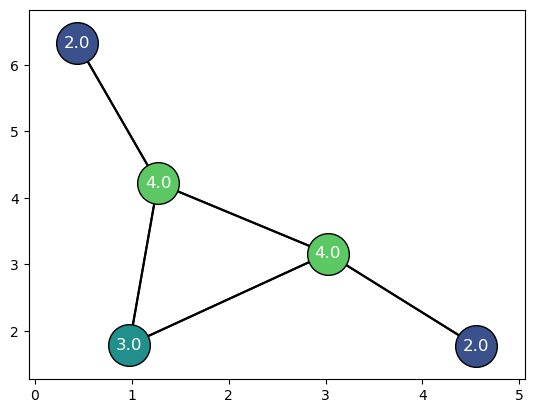

In [350]:
fig, ax = plt.subplots()
no_params_gnn = NoParamsGNN()
#ax.set_xlim([-5,5])
model = lambda graph: no_params_gnn(graph.x, graph.edge_index)
cnorm, cmap = get_cmap_colors(graphs=[g5],model=model, Nsteps=256, cmap=mpl.cm.viridis)
plot(ax=ax, graph=g5, cmap=cmap, cnorm=cnorm, model=model)

In [351]:
class PsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = torch.nn.Linear(d_in, d_out, bias=True)

    def forward(self, x, edge_index):
        x = self.propagate(edge_index, x=x)
        x = x.flatten()
        return x

    def message(self, x_j):
        return self.psi(x_j)

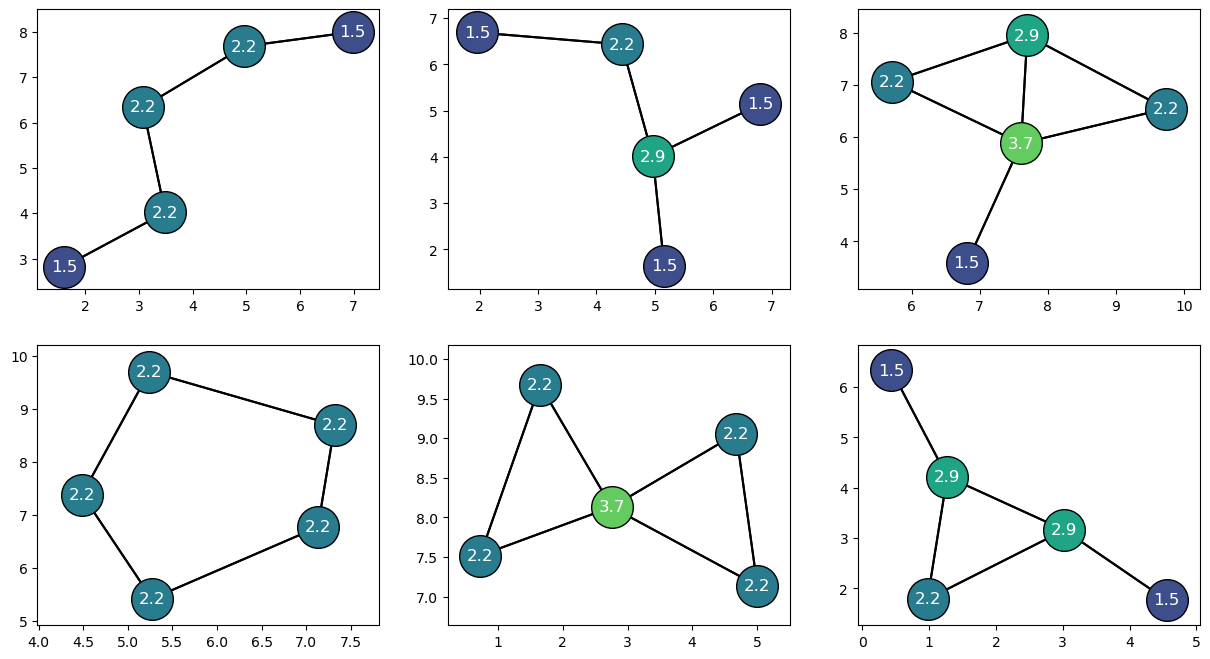

In [352]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
psi_gnn = PsiGNN(1,1)
graphs = [g0,g1,g2,g3,g4,g5]
model = lambda graph: psi_gnn(graph.x, graph.edge_index)
cnorm, cmap = get_cmap_colors(graphs=graphs,model=model, Nsteps=256, cmap=mpl.cm.viridis)
for graph, ax in zip(graphs, axs.flatten()):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=model)

In [353]:
epochs = 2500
train_graphs = [g0,g1,g2,g3,g4]
psi_gnn = PsiGNN(1,1)
optimizer = torch.optim.Adam(params=psi_gnn.parameters(), lr=1e-3)
loss_func = torch.nn.MSELoss()
for epoch in range(epochs):
    total_loss = 0
    for graph in train_graphs:
        optimizer.zero_grad()
        loss = loss_func(psi_gnn.forward(graph.x, graph.edge_index), graph.y.squeeze(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_graphs)
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 250/2500, Loss: 0.0665
Epoch 500/2500, Loss: 0.0665
Epoch 750/2500, Loss: 0.0665
Epoch 1000/2500, Loss: 0.0665
Epoch 1250/2500, Loss: 0.0665
Epoch 1500/2500, Loss: 0.0665
Epoch 1750/2500, Loss: 0.0665
Epoch 2000/2500, Loss: 0.0665
Epoch 2250/2500, Loss: 0.0665
Epoch 2500/2500, Loss: 0.0665


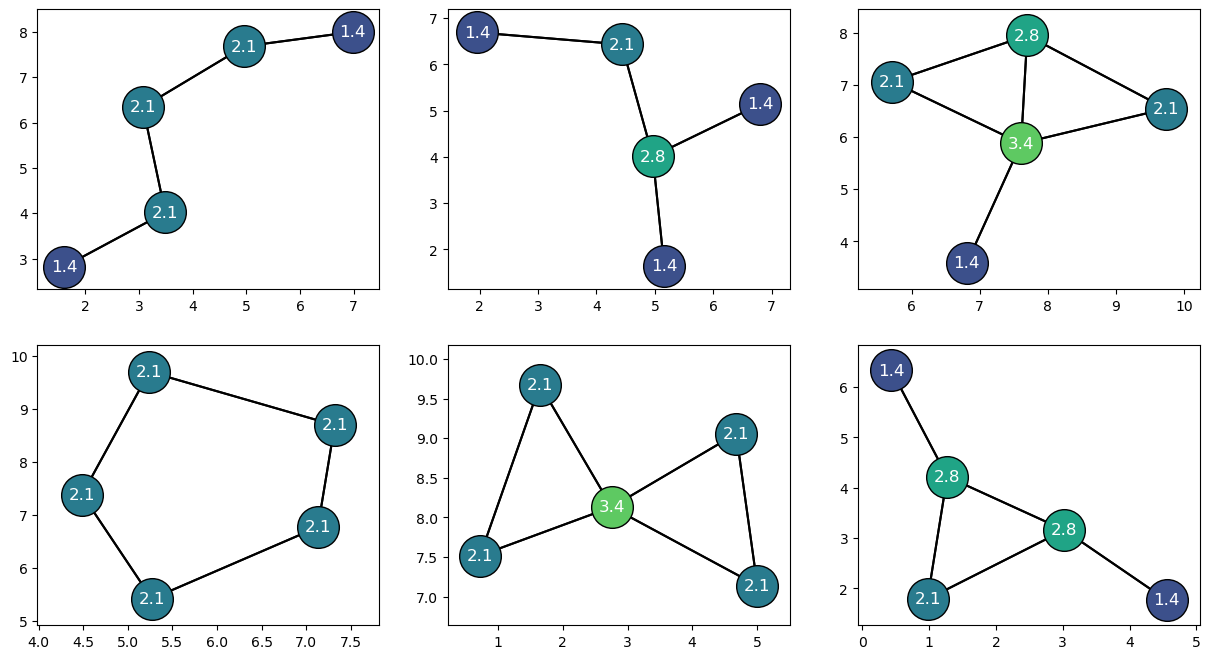

In [354]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
graphs = [g0,g1,g2,g3,g4,g5]
model = lambda graph: psi_gnn(graph.x, graph.edge_index)
cnorm, cmap = get_cmap_colors(graphs=graphs,model=model, Nsteps=256, cmap=mpl.cm.viridis)
for graph, ax in zip(graphs, axs.flatten()):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=model)

In [355]:
train_loader = DataLoader(train_graphs, batch_size=3, shuffle=True)
psi_gnn = PsiGNN(1,1)
optimizer = torch.optim.Adam(params=psi_gnn.parameters(), lr=1e-3)
loss_func = torch.nn.MSELoss()
for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    for graphs in train_loader:
        optimizer.zero_grad()
        loss = loss_func(psi_gnn.forward(graphs.x, graphs.edge_index), graphs.y.squeeze(-1))
        loss.backward()
        optimizer.step()
        N = len(graphs)
        total_N += N
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 250/2500, Loss: 0.0664
Epoch 500/2500, Loss: 0.0664
Epoch 750/2500, Loss: 0.0664
Epoch 1000/2500, Loss: 0.0664
Epoch 1250/2500, Loss: 0.0664
Epoch 1500/2500, Loss: 0.0664
Epoch 1750/2500, Loss: 0.0664
Epoch 2000/2500, Loss: 0.0664
Epoch 2250/2500, Loss: 0.0664
Epoch 2500/2500, Loss: 0.0664


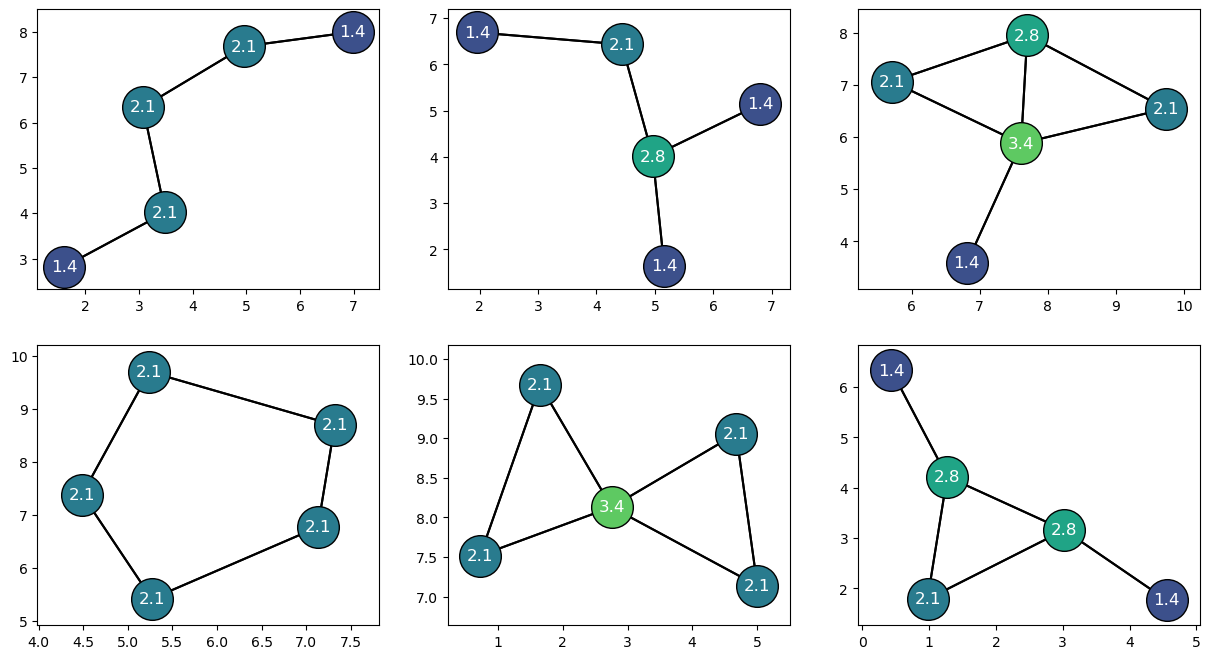

In [356]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
graphs = [g0,g1,g2,g3,g4,g5]
model = lambda graph: psi_gnn(graph.x, graph.edge_index)
cnorm, cmap = get_cmap_colors(graphs=graphs,model=model, Nsteps=256, cmap=mpl.cm.viridis)
for graph, ax in zip(graphs, axs.flatten()):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=model)

In [357]:
class PhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = torch.nn.Linear(d_in, d_out, bias=True)
        self.phi = torch.nn.Linear(d_in+d_out, d_out, bias=True)

    def forward(self, x, edge_index):
        psi_of_x_j = self.propagate(edge_index, x=x)
        x = self.phi(torch.hstack((x, psi_of_x_j)))
        return x.flatten()

    def message(self, x_j):
        return self.psi(x_j)

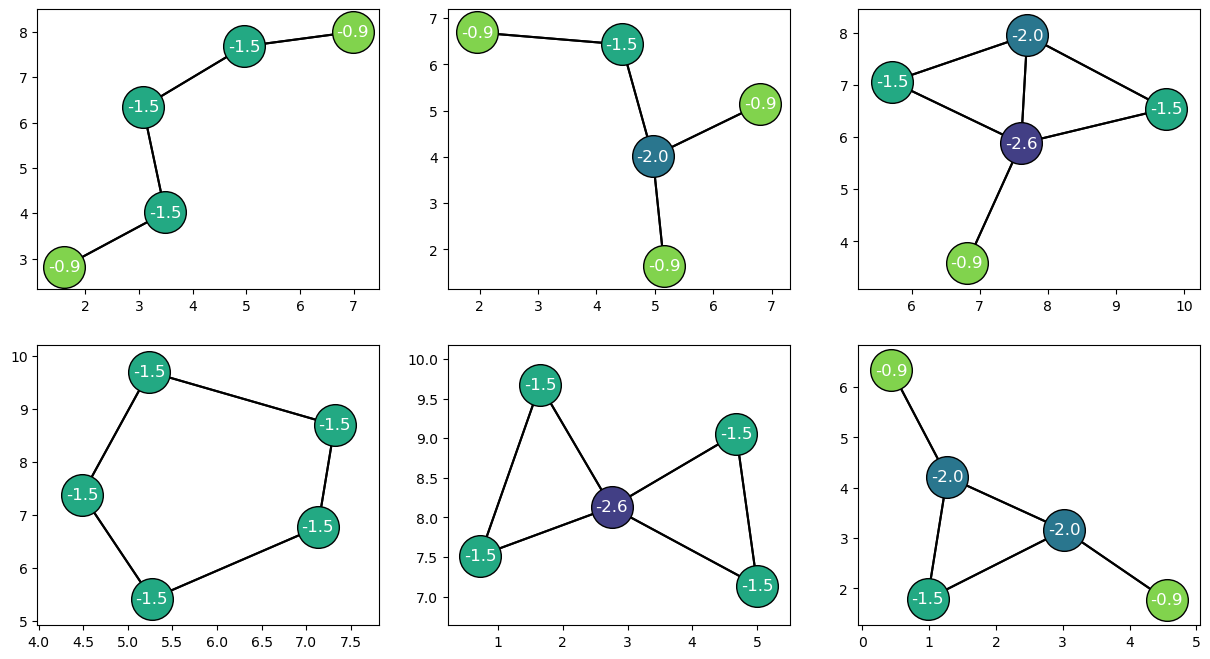

In [358]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
graphs = [g0,g1,g2,g3,g4,g5]
phi_psi_gnn = PhiPsiGNN(1,1)
model = lambda graph: phi_psi_gnn(graph.x, graph.edge_index)
cnorm, cmap = get_cmap_colors(graphs=graphs,model=model, Nsteps=256, cmap=mpl.cm.viridis, max_offset=0.5, min_offset=0.5)
for graph, ax in zip(graphs, axs.flatten()):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=model)

In [359]:
train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)
phi_psi_gnn = PhiPsiGNN(1,1)
optimizer = torch.optim.Adam(params=phi_psi_gnn.parameters(), lr=1e-3)
loss_func = torch.nn.MSELoss()
for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    for graphs in train_loader:
        optimizer.zero_grad()
        loss = loss_func(phi_psi_gnn.forward(graphs.x, graphs.edge_index), graphs.y.squeeze(-1))
        loss.backward()
        optimizer.step()
        N = len(graphs)
        total_N += N
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 250/2500, Loss: 0.0598
Epoch 500/2500, Loss: 0.0464
Epoch 750/2500, Loss: 0.0309
Epoch 1000/2500, Loss: 0.0169
Epoch 1250/2500, Loss: 0.0069
Epoch 1500/2500, Loss: 0.0019
Epoch 1750/2500, Loss: 0.0003
Epoch 2000/2500, Loss: 0.0000
Epoch 2250/2500, Loss: 0.0000
Epoch 2500/2500, Loss: 0.0000


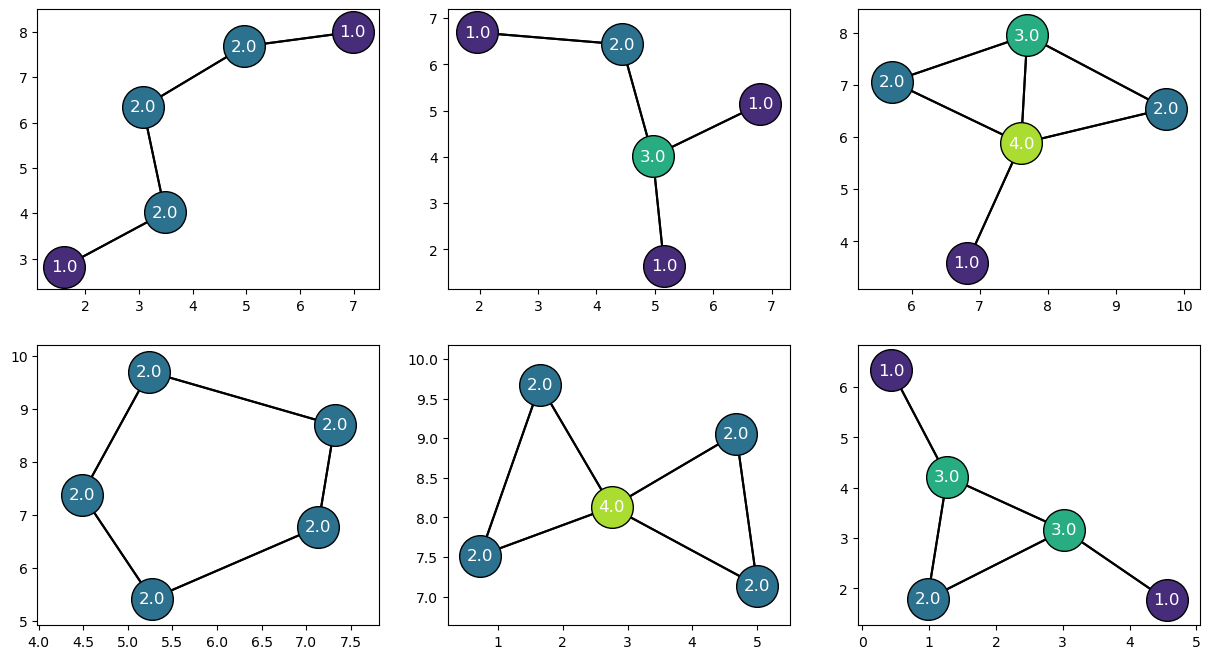

In [360]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
graphs = [g0,g1,g2,g3,g4,g5]
model = lambda graph: phi_psi_gnn(graph.x, graph.edge_index)
cnorm, cmap = get_cmap_colors(graphs=graphs,model=model, Nsteps=256, cmap=mpl.cm.viridis, max_offset=0.5, min_offset=0.5)
for graph, ax in zip(graphs, axs.flatten()):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=model)

In [380]:
from torch_geometric.nn.aggr import SumAggregation

def get_cmap_colors(graphs, model, cmap=mpl.cm.brg, Nsteps=10, max_val=None, min_val=None, min_offset=1.0, max_offset=1.0):
    if min_val is None:
        min_val = get_min_xval(graphs, model, min_offset)
    if max_val is None:
        max_val = get_max_xval(graphs, model, max_offset)
    bounds = torch.linspace(min_val, max_val, Nsteps)
    cnorm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cnorm, cmap

def plot(ax, graph, cmap, cnorm, model, label, **plot_kwargs):
    with torch.no_grad():
        positions = graph.pos
        edge_indices = graph.edge_index
        cons1 = positions[edge_indices[0]]
        cons2 = positions[edge_indices[1]]
        ax.set_xlim([torch.min(cons1[:,0])-0.5, torch.max(cons1[:,0])+0.5])
        ax.set_ylim([torch.min(cons1[:,1])-0.5, torch.max(cons1[:,1])+0.5])

        for con1, con2 in zip(cons1, cons2):
            ax.plot([con1[0], con2[0]], [con1[1], con2[1]], c="k")
        xs, y = model(graph)
        for i, position, x_val in zip(range(len(positions)), positions, xs):
            ax.plot(position[0], position[1], "o", markeredgecolor="k", color=cmap(cnorm(x_val)), ms=30, **plot_kwargs)
            ax.annotate(text=f"{round(x_val.item(),1)}", xy=(position), ha='center', va="center", color="white", fontsize=12)
        ax.set_title(f"Pred. nr. of bonds: {round(y.item(),1)}; Nr. of bonds {label}")


class AggrPhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = torch.nn.Linear(d_in, d_out, bias=True)
        self.phi = torch.nn.Linear(d_in+d_out, d_out, bias=True)
        self.aggr = SumAggregation()

    def forward(self, x, edge_index, batch):
        psi_of_x_j = self.propagate(edge_index, x=x)
        x = self.phi(torch.hstack((x, psi_of_x_j)))
        y = self.aggr(x, batch)
        return x,y # return both local and global prediction

    def message(self, x_j):
        return self.psi(x_j)

In [381]:
all_graphs_global_labels_only = []
for graph in [g0,g1,g2,g3,g4,g5]:
    g = Data(edge_index=graph.edge_index, x=graph.x, pos=graph.pos, y=torch.sum(graph.y/2))
    all_graphs_global_labels_only.append(g)

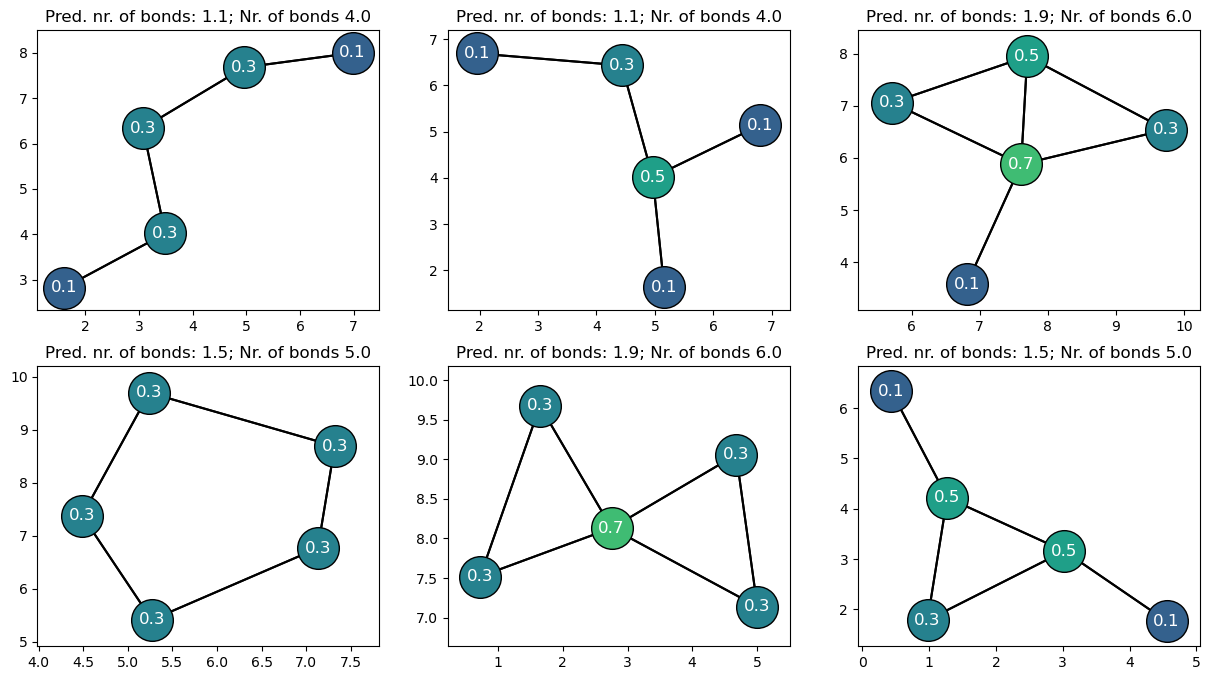

In [382]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
aggr_phi_psi_gnn = AggrPhiPsiGNN(1,1)
labels = [4.0, 4.0, 6.0, 5.0, 6.0, 5.0]
model = lambda graph: aggr_phi_psi_gnn(graph.x, graph.edge_index, graph.batch)
cnorm, cmap = get_cmap_colors(graphs=all_graphs_global_labels_only,model=model, Nsteps=256, cmap=mpl.cm.viridis, max_offset=0.5, min_offset=0.5)
for graph, ax, label in zip(all_graphs_global_labels_only, axs.flatten(), labels):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=model, label=label)

In [397]:
epochs=2500
train_loader = DataLoader(all_graphs_global_labels_only[0:-1], batch_size=1, shuffle=True)
aggr_phi_psi_gnn = AggrPhiPsiGNN(1,1)
optimizer = torch.optim.Adam(params=aggr_phi_psi_gnn.parameters(), lr=1e-3)
loss_func = torch.nn.MSELoss()
for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    for graphs in train_loader:
        optimizer.zero_grad()
        #print(graphs.y)
        #print(aggr_phi_psi_gnn.forward(graphs.x, graphs.edge_index, graphs.batch)[1])
        loss = loss_func(aggr_phi_psi_gnn.forward(graphs.x, graphs.edge_index, graphs.batch)[1], graphs.y.view(-1,1))
        loss.backward()
        optimizer.step()
        N = len(graphs)
        total_N += N
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 250/2500, Loss: 0.0501
Epoch 500/2500, Loss: 0.0422
Epoch 750/2500, Loss: 0.0318
Epoch 1000/2500, Loss: 0.0175
Epoch 1250/2500, Loss: 0.0072
Epoch 1500/2500, Loss: 0.0012
Epoch 1750/2500, Loss: 0.0001
Epoch 2000/2500, Loss: 0.0000
Epoch 2250/2500, Loss: 0.0000
Epoch 2500/2500, Loss: 0.0000


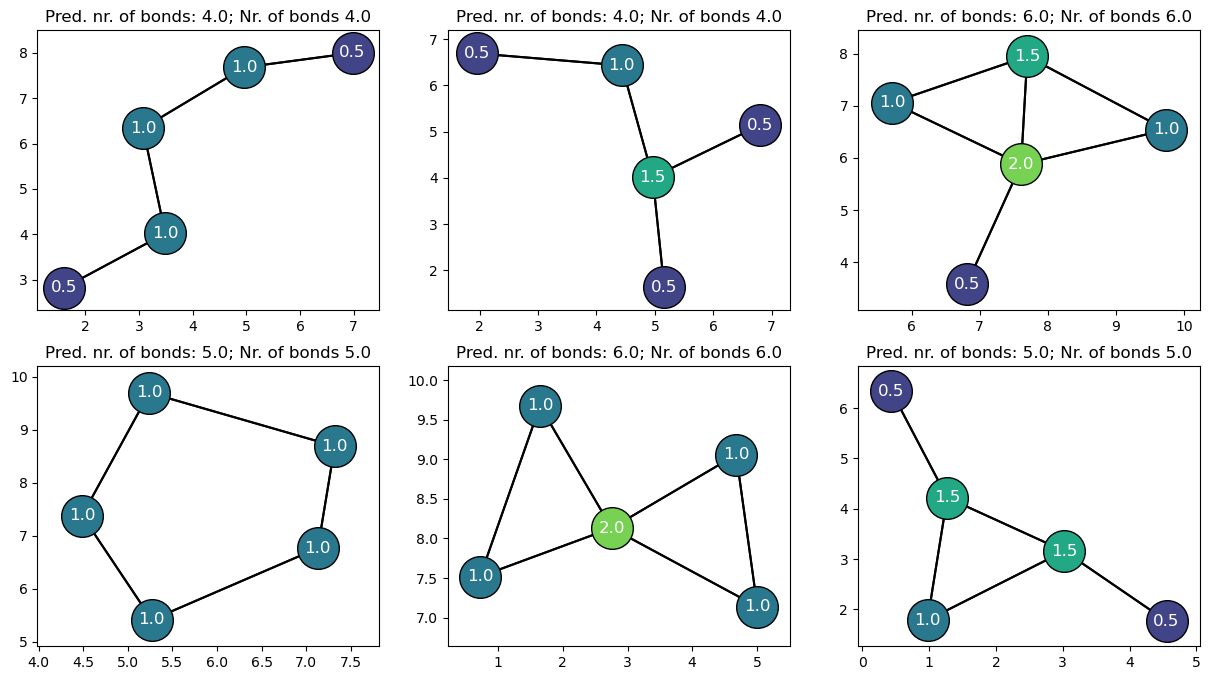

In [398]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
labels = [4.0, 4.0, 6.0, 5.0, 6.0, 5.0]
model = lambda graph: aggr_phi_psi_gnn(graph.x, graph.edge_index, graph.batch)
cnorm, cmap = get_cmap_colors(graphs=all_graphs_global_labels_only,model=model, Nsteps=256, cmap=mpl.cm.viridis, max_offset=0.5, min_offset=0.5)
for graph, ax, label in zip(all_graphs_global_labels_only, axs.flatten(), labels):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=model, label=label)